# Load Libraries

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd
import statsmodels.api as sm
import sklearn

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc

# Please pass your API key here
# pc.settings.set_subscription_key('********************')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm.notebook import tqdm as tqdm
tqdm.pandas()

# Read Data

In [2]:
crop_yield_data = pd.read_csv("Crop_Yield_Data_challenge_2.csv", parse_dates=['Date of Harvest'])
crop_yield_data.columns = ['district', 'latitude', 'longitude', 'season', 'intensity', 'date_of_harvest', 'field_size', 'rice_yield']
crop_yield_data.head()

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000
2,Chau_Phu,10.467721,105.192464,SA,D,2022-07-15,1.95,6400
3,Chau_Phu,10.494453,105.241281,SA,T,2022-07-15,4.30,6000
4,Chau_Phu,10.535058,105.252744,SA,D,2022-07-14,3.30,6400


In [3]:
crop_yield_data[crop_yield_data.duplicated(subset=['latitude', 'longitude'], keep=False)].sort_values(['latitude', 'longitude'])

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
449,Thoai_Son,10.195117,105.200047,SA,T,2022-07-20,3.20,5600
531,Thoai_Son,10.195117,105.200047,WS,T,2022-05-04,3.20,7200
445,Thoai_Son,10.208515,105.202809,SA,T,2022-07-20,2.67,6400
527,Thoai_Son,10.208515,105.202809,WS,T,2022-05-04,2.67,7200
451,Thoai_Son,10.227394,105.164987,SA,T,2022-07-20,3.00,5600
...,...,...,...,...,...,...,...,...
119,Chau_Phu,10.636733,105.155635,WS,T,2022-10-04,3.20,8000
28,Chau_Phu,10.649258,105.142121,SA,D,2022-05-08,1.75,6000
120,Chau_Phu,10.649258,105.142121,WS,D,2022-10-04,1.75,8000
29,Chau_Phu,10.663484,105.168203,SA,D,2022-05-08,3.00,6500


In [4]:
sub_sample = pd.read_csv("Challenge_2_submission_template.csv", parse_dates=['Date of Harvest'])
sub_sample.columns = ['id', 'district', 'latitude', 'longitude', 'season', 'intensity', 'date_of_harvest', 'field_size', 'rice_yield']
sub_sample.head()

,id,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield
0,1,Chau_Phu,10.542192,105.187920,WS,T,2022-10-04,1.40,NaN
1,2,Chau_Thanh,10.400189,105.331053,SA,T,2022-07-15,1.32,NaN
2,3,Chau_Phu,10.505489,105.203926,SA,D,2022-07-14,1.40,NaN
3,4,Chau_Phu,10.523520,105.138274,WS,D,2022-10-04,1.80,NaN
4,5,Thoai_Son,10.294660,105.248528,SA,T,2022-07-20,2.20,NaN


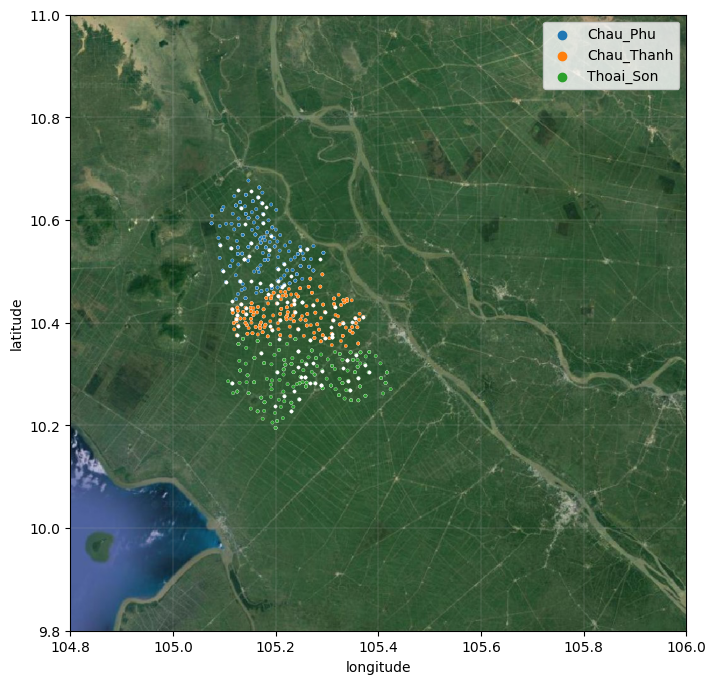

In [5]:
sns.scatterplot(data=crop_yield_data, x='longitude', y='latitude', hue='district', s=6)
sns.scatterplot(data=sub_sample, x='longitude', y='latitude', color='white', s=6)


fig = plt.gcf()
ax  = plt.gca()

fig.set_size_inches(8, 8)

ax.set_aspect('equal')
ax.patch.set_alpha(0)
plt.grid(lw=0.15)
plt.legend()
# legend.legendHandles[0]._sizes = [40]
# legend.legendHandles[1]._sizes = [40]
# legend.set_alpha(0)

plt.xlim(104.8, 106)
plt.ylim(9.8, 11)

# [0.06, 0, 0.95, 0.95]

newax = fig.add_axes(ax.get_position(), anchor='SW', zorder=-15)
# newax.set_position(ax.get_position())
newax.imshow(plt.imread('../Full Region no labels.jpg'), aspect='auto')
newax.axis('off')
# ax.set_xlim(105.3338 - 10**-2/2, 105.3338+ 10**-2/2)
# ax.set_ylim(10.4391  - 10**-2/2, 10.4391 + 10**-2/2)
# newax.set_xlim(105.3338 - 10**-2/2, 105.3338+ 10**-2/2)
# newax.set_ylim(10.4391  - 10**-2/2, 10.4391 + 10**-2/2)
plt.grid(False)

# Process Data

## Constant Features

<AxesSubplot:>

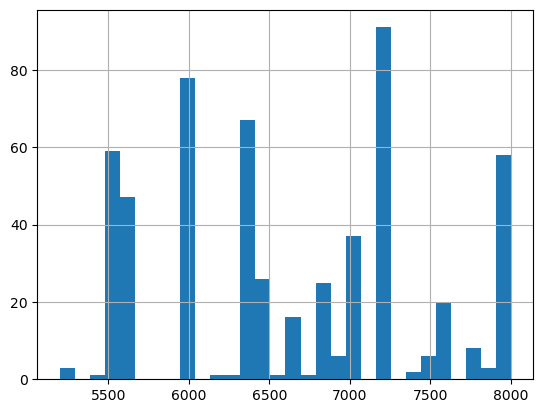

In [6]:
crop_yield_data['rice_yield'].hist(bins=30)

<AxesSubplot:>

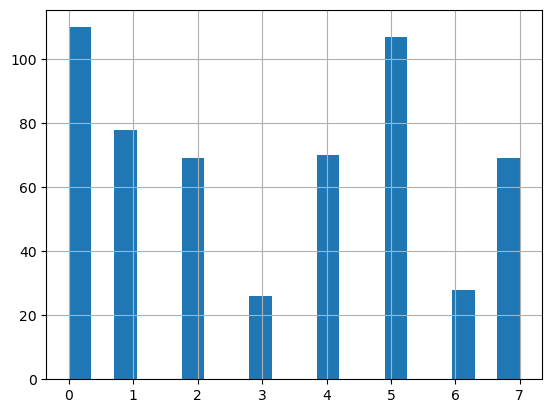

In [7]:
crop_yield_data['target_class'] = pd.qcut(crop_yield_data['rice_yield'], q=8, labels=False)
crop_yield_data['target_class'].hist(bins=20)

In [8]:
crop_yield_data.head(2)

,district,latitude,longitude,season,intensity,date_of_harvest,field_size,rice_yield,target_class
0,Chau_Phu,10.510542,105.248554,SA,T,2022-07-15,3.40,5500,0
1,Chau_Phu,10.509150,105.265098,SA,T,2022-07-15,2.43,6000,1


In [9]:
train_const_data = pd.get_dummies(crop_yield_data.drop(['district'], axis=1), drop_first=True).drop(['latitude', 'longitude'], axis=1)
sub_const_data   = pd.get_dummies(sub_sample.drop(['district', 'rice_yield', 'id'], axis=1), drop_first=True).drop(['latitude', 'longitude'], axis=1)
display(train_const_data.head(2), sub_const_data.head(2))

,date_of_harvest,field_size,rice_yield,target_class,season_WS,intensity_T
0,2022-07-15,3.40,5500,0,0,1
1,2022-07-15,2.43,6000,1,0,1


,date_of_harvest,field_size,season_WS,intensity_T
0,2022-10-04,1.40,1,1
1,2022-07-15,1.32,0,1


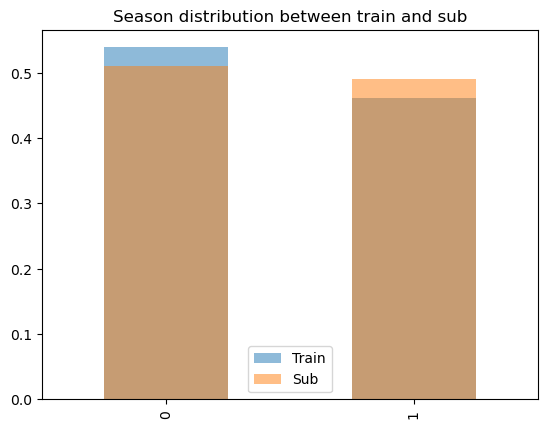

In [10]:
train_const_data.season_WS.value_counts(normalize=True).plot.bar(alpha=0.5, label='Train')
sub_const_data.season_WS.value_counts(normalize=True).plot.bar(alpha=0.5, color='C1', label='Sub')
plt.title('Season distribution between train and sub')
plt.legend();

In [11]:
train_const_data['start_of_harvest']     = train_const_data.date_of_harvest - pd.to_timedelta('97d')
sub_const_data  ['start_of_harvest']     = sub_const_data.date_of_harvest -   pd.to_timedelta('97d')
train_const_data['dayofyear_of_harvest'] = train_const_data.date_of_harvest.dt.day_of_year
sub_const_data['dayofyear_of_harvest']   = sub_const_data.date_of_harvest.dt.day_of_year
display(train_const_data.head(2), sub_const_data.head(2))

,date_of_harvest,field_size,rice_yield,target_class,season_WS,intensity_T,start_of_harvest,dayofyear_of_harvest
0,2022-07-15,3.40,5500,0,0,1,2022-04-09,196
1,2022-07-15,2.43,6000,1,0,1,2022-04-09,196


,date_of_harvest,field_size,season_WS,intensity_T,start_of_harvest,dayofyear_of_harvest
0,2022-10-04,1.40,1,1,2022-06-29,277
1,2022-07-15,1.32,0,1,2022-04-09,196


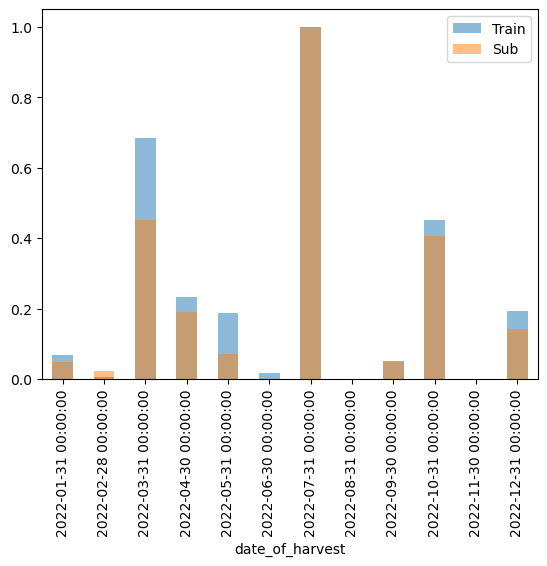

<AxesSubplot:>

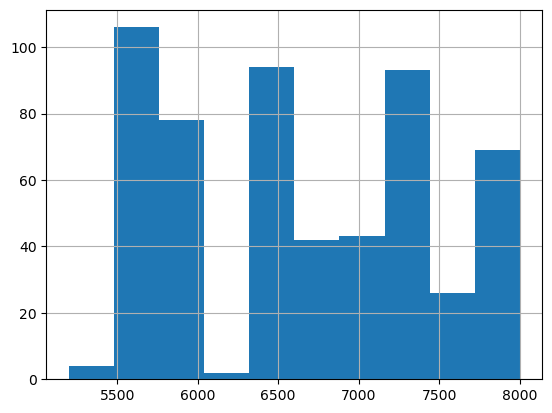

In [12]:
train_const_data.set_index('date_of_harvest').resample('m').count().apply(lambda x:x/x.max()).iloc[:, 0].plot.bar(alpha=0.5, label='Train')
sub_const_data.set_index('date_of_harvest').resample('m').count().apply(lambda x:x/x.max()).iloc[:, 0].plot.bar(alpha=0.5, color='C1', label='Sub')
plt.legend()
plt.show()
train_const_data.rice_yield.hist(bins=10)

In [13]:
# sns.kdeplot(data=train_const_data, x='date_of_harvest', y='rice_yield', hue='intensity_T', levels=8, fill=True, alpha=0.5)
# plt.title('Yield by date and by intensity')

In [14]:
# sns.heatmap(train_const_data.corr(), cmap='coolwarm', annot=True)

In [15]:
# sns.pairplot(train_const_data)

In [16]:
# sns.pairplot(sub_const_data)

## Time Series features

In [17]:
train_ts_data = pd.read_csv('train_data_level2.csv', index_col=['index', 'datetime'], parse_dates=True)
sub_ts_data   = pd.read_csv('sub_data_level2.csv'  , index_col=['index', 'datetime'], parse_dates=True)
# train_sent2_data = pd.read_csv('train_sentinel2_level2_fix.csv', index_col=['index', 'datetime'], parse_dates=True).drop('SCL', axis=1).replace(0, np.nan)
# sub_sent2_data = pd.read_csv('sub_sentinel2_level2.csv', index_col=['index', 'datetime'], parse_dates=True).drop('SCL', axis=1).replace(0, np.nan)

train_sent2_data = pd.read_pickle('../level2_sent2_train.df')
sub_sent2_data   = pd.read_pickle('../level2_sent2_sub.df'  )

display(train_ts_data.head(2), train_sent2_data.head(2), sub_sent2_data.head(2))

vh        vv       rvi
index datetime                                                
0     2021-09-05 22:45:35.619475  0.006411  0.036697  0.229400
      2021-09-11 22:46:08.311308  0.019033  0.295205  0.059627

red                                      \
                                  mean  median percentile_20 percentile_80   
  time                                                                       
0 2022-02-19 03:17:49.024  1649.775391  1406.5        1251.0        2036.0   
  2022-02-24 03:17:31.024          NaN     NaN           NaN           NaN   

                                             green                        \
                                  std         mean  median percentile_20   
  time                                                                     
0 2022-02-19 03:17:49.024  543.111408  1933.546509  1693.0        1556.0   
  2022-02-24 03:17:31.024         NaN          NaN     NaN           NaN   

                                                    ...      rededge          \
                          percentile_80        std  ...         mean  median   
  time                                              ...                        
0 2022-02-19 03:17:49.024   2336.399902  538.90375  ...  2205.781982  1990.5   
  2022-02-24 03:17:31.024           NaN        NaN  ...          NaN     NaN   

                                                                   \
                          percentile_20 percentile_80         std   
  time                                                              
0 2022-02-19 03:17:49.024        1798.0   2595.600098  581.085265   
  2022-02-24 03:17:31.024           NaN           NaN         NaN   

                                swir16                                      \
                                  mean  median percentile_20 percentile_80   
  time                                                                       
0 2022-02-19 03:17:49.024  3068.577881  2948.0   2656.399902   3432.600098   
  2022-02-24 03:17:31.024          NaN     NaN           NaN           NaN   

                                       
                                  std  
  time                                 
0 2022-02-19 03:17:49.024  605.145364  
  2022-02-24 03:17:31.024         NaN  

[2 rows x 30 columns]

red                                        green  \
                          mean median percentile_20 percentile_80 std  mean   
  time                                                                        
0 2021-11-11 03:19:49.024  NaN    NaN           NaN           NaN NaN   NaN   
  2021-11-16 03:20:11.024  NaN    NaN           NaN           NaN NaN   NaN   

                                                                  ... rededge  \
                          median percentile_20 percentile_80 std  ...    mean   
  time                                                            ...           
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN  ...     NaN   
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN  ...     NaN   

                                                                 swir16  \
                          median percentile_20 percentile_80 std   mean   
  time                                                                    
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN    NaN   
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN    NaN   

                                                                  
                          median percentile_20 percentile_80 std  
  time                                                            
0 2021-11-11 03:19:49.024    NaN           NaN           NaN NaN  
  2021-11-16 03:20:11.024    NaN           NaN           NaN NaN  

[2 rows x 30 columns]

In [18]:
# Add ratio vv/vh
# train_ts_data = train_ts_data.assign(ratio=lambda x:x['vv']/x['vh']/10)
# sub_ts_data = sub_ts_data.assign(ratio=lambda x:x['vv']/x['vh']/10)
# display(train_ts_data.head(2), sub_ts_data.head(2))

# Add Indices to Sentinel 2
def AddBands(sent2_data, multiindex):
    if multiindex:
        sent2_data = sent2_data.stack()
    sent2_data = sent2_data.assign(ndvi =lambda x:(x.nir-x.red)/(x.nir+x.red),
                                           ndwi =lambda x:(x.nir-x.swir16)/(x.nir+x.swir16),
                                           ndbsi=lambda x:((x.nir+x.blue)-(x.red+x.swir16))/((x.nir+x.blue)+(x.red+x.swir16)),
                                           ndre =lambda x:(x.nir-x.rededge)/(x.nir+x.rededge))
    if multiindex:
        sent2_data = sent2_data.unstack()
    return sent2_data

train_sent2_data = AddBands(train_sent2_data, True)
sub_sent2_data = AddBands(sub_sent2_data, True)
display(train_sent2_data.head(), sub_sent2_data.head())

red                                      \
                                  mean  median percentile_20 percentile_80   
  time                                                                       
0 2022-02-19 03:17:49.024  1649.775391  1406.5   1251.000000        2036.0   
  2022-03-01 03:16:49.024  1348.125000  1311.0   1268.000000        1360.0   
  2022-03-06 03:16:21.024  1854.875732  1830.0   1605.000000        2124.0   
  2022-03-11 03:15:39.024  1539.277344  1496.0   1452.000000        1558.0   
  2022-03-21 03:15:39.024  2499.475586  2524.0   2381.600098        2642.0   

                                             green                        \
                                  std         mean  median percentile_20   
  time                                                                     
0 2022-02-19 03:17:49.024  543.111408  1933.546509  1693.0        1556.0   
  2022-03-01 03:16:49.024  159.966914  1601.489746  1578.0        1527.0   
  2022-03-06 03:16:21.024  278.975257  2136.828369  2102.0        1894.0   
  2022-03-11 03:15:39.024  196.676635  1822.662109  1796.0        1746.0   
  2022-03-21 03:15:39.024  165.571325  2704.537109  2728.0        2584.0   

                                                     ...     ndbsi            \
                          percentile_80         std  ...      mean    median   
  time                                               ...                       
0 2022-02-19 03:17:49.024   2336.399902  538.903750  ...  0.204254  0.233633   
  2022-03-01 03:16:49.024   1641.000000  125.252440  ...  0.228254  0.239823   
  2022-03-06 03:16:21.024   2406.000000  288.589611  ...  0.179755  0.181930   
  2022-03-11 03:15:39.024   1868.000000  182.674293  ...  0.213523  0.226056   
  2022-03-21 03:15:39.024   2860.000000  183.010136  ...  0.093649  0.094440   

                                                                     ndre  \
                          percentile_20 percentile_80       std      mean   
  time                                                                      
0 2022-02-19 03:17:49.024      0.214008      0.205596  0.112829  0.419817   
  2022-03-01 03:16:49.024      0.220788      0.251032  0.348283  0.417205   
  2022-03-06 03:16:21.024      0.183907      0.175326  0.191298  0.319242   
  2022-03-11 03:15:39.024      0.204480      0.234763  0.309228  0.366587   
  2022-03-21 03:15:39.024      0.090780      0.095886  0.159653  0.149021   

                                                                           
                             median percentile_20 percentile_80       std  
  time                                                                     
0 2022-02-19 03:17:49.024  0.471350      0.445164      0.408720  0.209851  
  2022-03-01 03:16:49.024  0.428571      0.410419      0.436040  0.608392  
  2022-03-06 03:16:21.024  0.325931      0.330387      0.303652  0.240843  
  2022-03-11 03:15:39.024  0.378747      0.354063      0.390245  0.521250  
  2022-03-21 03:15:39.024  0.148461      0.150544      0.145363  0.104414  

[5 rows x 50 columns]

red                                      \
                                  mean  median percentile_20 percentile_80   
  time                                                                       
0 2021-11-21 03:20:29.024   758.519165   630.0    512.799988    942.200012   
  2021-11-26 03:20:51.024   587.637634   542.0    427.200012    686.799988   
  2021-12-06 03:21:21.024  1036.578857  1068.0    776.599976   1316.000000   
  2021-12-21 03:21:39.024   889.135925   857.0    674.799988   1084.000000   
  2021-12-26 03:21:41.024  1357.424316  1272.0    882.000000   1774.000000   

                                             green                        \
                                  std         mean  median percentile_20   
  time                                                                     
0 2021-11-21 03:20:29.024  397.815948  1068.134399   961.0    812.799988   
  2021-11-26 03:20:51.024  295.000420   805.806946   756.0    639.000000   
  2021-12-06 03:21:21.024  358.268557   973.721619   957.0    775.000000   
  2021-12-21 03:21:39.024  266.706378   782.941650   753.0    612.000000   
  2021-12-26 03:21:41.024  560.521788  1295.639160  1217.0    906.000000   

                                                     ...     ndbsi            \
                          percentile_80         std  ...      mean    median   
  time                                               ...                       
0 2021-11-21 03:20:29.024   1264.400024  398.775339  ...  0.243468  0.264246   
  2021-11-26 03:20:51.024    926.799988  300.779221  ...  0.206413  0.210310   
  2021-12-06 03:21:21.024   1176.000000  290.065243  ...  0.063750  0.052026   
  2021-12-21 03:21:39.024    924.200012  215.101306  ...  0.064571  0.083747   
  2021-12-26 03:21:41.024   1584.000000  500.581360  ...  0.132731  0.159804   

                                                                     ndre  \
                          percentile_20 percentile_80       std      mean   
  time                                                                      
0 2021-11-21 03:20:29.024      0.241890      0.251388  0.202453  0.436857   
  2021-11-26 03:20:51.024      0.198688      0.219185  0.229133  0.407671   
  2021-12-06 03:21:21.024      0.076792      0.053203  0.020994  0.272885   
  2021-12-21 03:21:39.024      0.156673      0.015364 -0.029350  0.116563   
  2021-12-26 03:21:41.024      0.237410      0.088243 -0.001749  0.068620   

                                                                           
                             median percentile_20 percentile_80       std  
  time                                                                     
0 2021-11-21 03:20:29.024  0.469328      0.451329      0.441430  0.370255  
  2021-11-26 03:20:51.024  0.417609      0.420841      0.409450  0.341555  
  2021-12-06 03:21:21.024  0.263078      0.342020      0.248623  0.094852  
  2021-12-21 03:21:39.024  0.050906     -0.021493      0.200292  0.459844  
  2021-12-26 03:21:41.024  0.069699      0.003448      0.107120  0.153583  

[5 rows x 50 columns]

In [19]:
train_sent2_data = train_sent2_data.xs('percentile_80', axis=1, level=1)
sub_sent2_data = sub_sent2_data.xs('percentile_80', axis=1, level=1)

In [20]:
# Drop a column
# train_sent2_data = train_sent2_data.drop(['red', 'green', 'blue'], axis=1)
# sub_sent2_data = sub_sent2_data.drop(['red', 'green', 'blue'], axis=1)

# display(train_sent2_data.head(2), sub_sent2_data.head(2))

In [21]:
def is_outlier(series, factor=1, print_range=False):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR*factor
    upper_bound = Q3 + 1.5 * IQR*factor
    if print_range:
        print(upper_bound, lower_bound)
    boolean_filter = (series < lower_bound) | (series > upper_bound)
    return pd.Series(np.where(boolean_filter,
                                       np.nan,
                                       series),
                              index=series.index)

In [22]:
# Transformación de variables sentinel 1
train_ts_data[['vv', 'vh']] = train_ts_data[['vv', 'vh']].apply(lambda x:np.log10(x))
train_ts_data['rvi'] = train_ts_data['rvi'].apply(lambda x:x**0.5)
sub_ts_data[['vv', 'vh']] = sub_ts_data[['vv', 'vh']].apply(lambda x:np.log10(x))
sub_ts_data['rvi'] = sub_ts_data['rvi'].apply(lambda x:x**0.5)

In [23]:
# Transformación de variables sentinel 2
train_sent2_data.loc[:, 'red,green,blue,nir,rededge,swir16'.split(',')] = train_sent2_data['red,green,blue,nir,rededge,swir16'.split(',')].apply(lambda x:np.log10(x))
sub_sent2_data.loc[  :, 'red,green,blue,nir,rededge,swir16'.split(',')] = sub_sent2_data[  'red,green,blue,nir,rededge,swir16'.split(',')].apply(lambda x:np.log10(x))

In [24]:
# Check boxplot with different outliers filters
# train_ts_data.plot.box()
# sub_ts_data.plot.box()
# train_sent2_data.plot.box()
# sub_sent2_data.plot.box()

In [25]:
train_ts_data    = train_ts_data.apply(is_outlier, args=[10])
sub_ts_data      = sub_ts_data.apply(  is_outlier, args=[10])
train_sent2_data = train_sent2_data.apply(is_outlier, args=[10])
sub_sent2_data   = sub_sent2_data.apply(is_outlier, args=[10])

In [26]:
# Check boxplot after outlier filters
# train_ts_data.plot.box()
# sub_ts_data.plot.box()
# train_sent2_data.plot.box()
# sub_sent2_data.plot.box()

### Slicing time frame

In [27]:
train_ts_data.reset_index(level=1).groupby(level=0)\
.apply(lambda x: x.set_index('datetime').resample('1d').median())

vh        vv       rvi
index datetime                                
0     2021-09-05 -2.193083 -1.435365  0.478958
      2021-09-06       NaN       NaN       NaN
      2021-09-07       NaN       NaN       NaN
      2021-09-08       NaN       NaN       NaN
      2021-09-09       NaN       NaN       NaN
...                    ...       ...       ...
556   2022-12-20       NaN       NaN       NaN
      2022-12-21       NaN       NaN       NaN
      2022-12-22       NaN       NaN       NaN
      2022-12-23 -2.160165 -0.943620  0.234108
      2022-12-24 -2.162919 -1.291836  0.404201

[265132 rows x 3 columns]

In [28]:
train_ts_data = pd.concat([train_ts_data, train_sent2_data], axis=1)
sub_ts_data   = pd.concat([sub_ts_data   , sub_sent2_data] , axis=1)

In [29]:
train_ts_data    = train_ts_data.unstack(    level=0).resample('1w').mean().interpolate().bfill().ffill().stack(dropna=False).swaplevel().sort_index(level=0)
sub_ts_data      = sub_ts_data.unstack(      level=0).resample('1w').mean().interpolate().bfill().ffill().stack(dropna=False).swaplevel().sort_index(level=0)

In [30]:
# Create slices to keep only 100 days prior to harvest for each coordinate

harvest_slices = []
for idx in range(len(train_ts_data.index.levels[0])):
    harvest_slices.append((idx, slice(train_const_data.loc[idx, 'start_of_harvest'], train_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(train_ts_data.loc[hs, :])
    
# Concatenate slices
train_ts_data = pd.concat(data_slices)

# Sub
harvest_slices = []
for idx in range(len(sub_ts_data.index.levels[0])):
    harvest_slices.append((idx, slice(sub_const_data.loc[idx, 'start_of_harvest'], sub_const_data.loc[idx, 'date_of_harvest'])))
data_slices = []
for hs in harvest_slices:
    data_slices.append(sub_ts_data.loc[hs, :])
    
# Concatenate slices
sub_ts_data = pd.concat(data_slices)

499


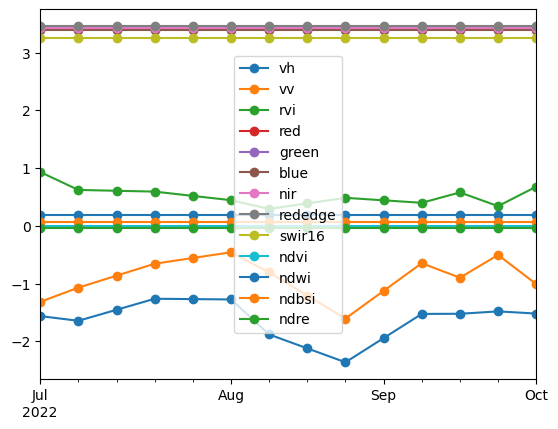

42


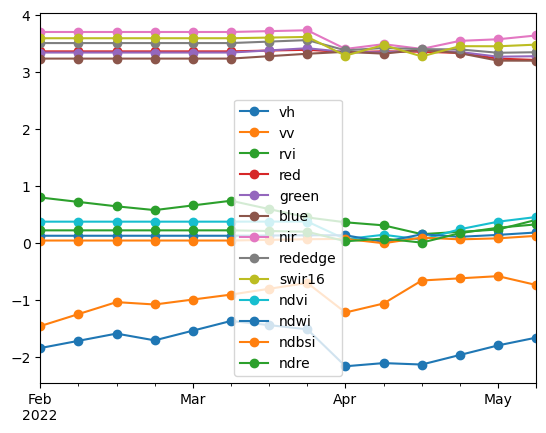

In [31]:
# Visualize data for one random sample
rand = np.random.randint(0, 556)
print(rand)
train_ts_data.loc[rand].plot(marker='o')
# [plt.axvline(train_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
plt.show();

# Visualize data for one random sample
rand = np.random.randint(0, 99)
print(rand)
sub_ts_data.loc[49].plot(marker='o')
# [plt.axvline(sub_const_data.loc[rand, i], c='k', ls='--', alpha=0.5) for i in ['start_of_harvest', 'date_of_harvest']];
plt.show();

### Detect TS Anomalies

In [32]:
# import torch
import torch.nn as nn

# Define a simple RNN model with one hidden layer
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Feed input sequence through the LSTM
        out, _ = self.rnn(x, (h0, c0))

        # Pass the output sequence through a fully connected layer
        out = self.fc(out)

        return out

# Define a loss function that penalizes large deviations from the predicted values
class AnomalyDetectionLoss(nn.Module):
    def __init__(self, threshold):
        super(AnomalyDetectionLoss, self).__init__()
        self.threshold = threshold

    def forward(self, y_pred, y_true):
        errors = torch.abs(y_pred - y_true)
        mask = errors > self.threshold
        loss = torch.mean(torch.where(mask, errors, torch.zeros_like(errors)))
        return loss

# Define a training function that uses an optimizer to minimize the loss
def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
    for epoch in range(num_epochs):
        for i, (inputs) in enumerate(train_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, inputs)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()), end='\r')

# Define a function to detect anomalies in a time series
def detect_anomalies(model, data, threshold):
    inputs = torch.Tensor(data)
    outputs = model(inputs)
    print(inputs.shape, outputs.shape)
    errors = torch.abs(outputs - inputs)
    mask = errors > threshold
    return mask.squeeze().detach().cpu().numpy()

# # Example usage:
# threshold = 3
# data = torch.Tensor(np.vstack([train_ts_data.values.reshape(557, 100, -1), sub_ts_data.values.reshape(100, 100, -1)])).to('cuda')
# model = RNN(input_size=data.shape[2], hidden_size=10, output_size=data.shape[2]).to('cuda')
# optimizer = torch.optim.Adam(model.parameters(), lr=10**-4)
# loss_fn = AnomalyDetectionLoss(threshold=threshold)
# train_loader = torch.utils.data.DataLoader(data, batch_size=1, shuffle=False)
# train_model(model, train_loader, optimizer, loss_fn, num_epochs=20)

In [33]:
# anomaly_mask_train = detect_anomalies(model, data[:557], threshold=threshold*0.35)
# anomaly_mask_sub   = detect_anomalies(model, data[557:], threshold=threshold*0.35)

In [34]:
# anomaly_mask_train_df = pd.DataFrame(anomaly_mask_train.reshape(train_ts_data.shape), index=train_ts_data.index, columns=train_ts_data.columns)
# anomaly_mask_sub_df   = pd.DataFrame(anomaly_mask_sub.reshape(sub_ts_data.shape)  , index=sub_ts_data.index  , columns=sub_ts_data.columns)

In [35]:
# # Join red, blue, green masks, and ndbi, etc, masks
# anomaly_mask_train_df[anomaly_mask_train_df.columns[3:8]] = anomaly_mask_train_df.iloc[:, 3:8].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_train_df.columns[3:8])
# anomaly_mask_train_df[anomaly_mask_train_df.columns[9:]]  = anomaly_mask_train_df.iloc[:, 9: ].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_train_df.columns[9:])
# anomaly_mask_train_df = anomaly_mask_train_df.ffill(axis=1)

# anomaly_mask_sub_df[anomaly_mask_sub_df.columns[3:8]] = anomaly_mask_sub_df.iloc[:, 3:8].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_sub_df.columns[3:8])
# anomaly_mask_sub_df[anomaly_mask_sub_df.columns[9:]]  = anomaly_mask_sub_df.iloc[:, 9: ].apply(np.logical_or.reduce, axis=1).to_frame().reindex(columns=anomaly_mask_sub_df.columns[9:])
# anomaly_mask_sub_df = anomaly_mask_sub_df.ffill(axis=1)

In [36]:
# iterator = iter(range(0, 50))

In [37]:
# n = next(iterator)
# print(n)
# # n = 18
# # print(pd.DataFrame(anomaly_mask).stack().xs(n))
# for f in range(13):
#     plt.scatter(y=train_ts_data.iloc[:, f].xs(n).values, x=train_ts_data.iloc[:, f].xs(n).index, color=['gold' if x else 'blue' for x in anomaly_mask_train_df.xs(n).iloc[:, f]], zorder=100)
#     train_ts_data.iloc[:, f].xs(n).plot()
#     plt.title(train_ts_data.iloc[:, f].name)
#     plt.show();

In [38]:
# train_ts_data = train_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.rolling(3).median().bfill())
# sub_ts_data   = sub_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.rolling(3).median().bfill())

In [39]:
# # Fix and then fill nas
# train_ts_data = train_ts_data.groupby(pd.Grouper(level=0)).apply(lambda x:x.interpolate(limit_area='inside').ffill().bfill().fillna(0).rolling(3).median().bfill())
# sub_ts_data   = sub_ts_data.groupby(  pd.Grouper(level=0)).apply(lambda x:x.interpolate(limit_area='inside').ffill().bfill().fillna(0).rolling(3).median().bfill())

In [40]:
# n = next(iterator)
# print(n)
# n = 1
# # print(pd.DataFrame(anomaly_mask).stack().xs(n))
# for f in range(13):
#     plt.scatter(y=train_ts_data.iloc[:, f].xs(n).values, x=train_ts_data.iloc[:, f].xs(n).index, color=['gold' if x else 'blue' for x in anomaly_mask_train_df.xs(n).iloc[:, f]], zorder=100)
#     train_ts_data.iloc[:, f].xs(n).plot()
#     plt.title(train_ts_data.iloc[:, f].name)
#     plt.show();

### Check

In [41]:
# Check that all time_series are the same length
display(train_ts_data.groupby(level=0).count().iloc[:, 0].describe(),
        sub_ts_data.groupby(level=0).count().iloc[:, 0].describe())

count    557.0
mean      14.0
std        0.0
min       14.0
25%       14.0
50%       14.0
75%       14.0
max       14.0
Name: vh, dtype: float64

count    100.0
mean      14.0
std        0.0
min       14.0
25%       14.0
50%       14.0
75%       14.0
max       14.0
Name: vh, dtype: float64

In [42]:
display(train_ts_data.isna().sum(),
        sub_ts_data.isna().sum())

vh         0
vv         0
rvi        0
red        0
green      0
blue       0
nir        0
rededge    0
swir16     0
ndvi       0
ndwi       0
ndbsi      0
ndre       0
dtype: int64

vh         0
vv         0
rvi        0
red        0
green      0
blue       0
nir        0
rededge    0
swir16     0
ndvi       0
ndwi       0
ndbsi      0
ndre       0
dtype: int64

## Extra constant features (time series descriptors)

In [43]:
def ordinal_distribution(data, dx=3, dy=1, taux=1, tauy=1, return_missing=False, tie_precision=None):
    '''
    Returns
    -------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.
       
    Attributes
    ---------
    data : array 
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    dy : int
         Embedding dimension (vertical axis); it must be 1 for time series 
         (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    return_missing: boolean
                    If `True`, it returns ordinal patterns not appearing in the 
                    symbolic sequence obtained from **data** are shown. If `False`,
                    these missing patterns (permutations) are omitted 
                    (default: `False`).
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
   
    '''
    def setdiff(a, b):
        '''
        Returns
        -------
        : array
            An array containing the elements in `a` that are not contained in `b`.
            
        Parameters
        ----------    
        a : tuples, lists or arrays
            Array in the format :math:`[[x_{100}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        b : tuples, lists or arrays
            Array in the format :math:`[[x_{100}, x_{22}, x_{23}, \\ldots, x_{2m}], 
            \\ldots, [x_{n1}, x_{n2}, x_{n3}, ..., x_{nm}]]`.
        '''

        a = np.asarray(a).astype('int64')
        b = np.asarray(b).astype('int64')

        _, ncols = a.shape

        dtype={'names':['f{}'.format(i) for i in range(ncols)],
            'formats':ncols * [a.dtype]}

        C = np.setdiff1d(a.view(dtype), b.view(dtype))
        C = C.view(a.dtype).reshape(-1, ncols)

        return(C)

    try:
        ny, nx = np.shape(data)
        data   = np.array(data)
    except:
        nx     = np.shape(data)[0]
        ny     = 1
        data   = np.array([data])

    if tie_precision is not None:
        data = np.round(data, tie_precision)

    partitions = np.concatenate(
        [
            [np.concatenate(data[j:j+dy*tauy:tauy,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
            for j in range(ny-(dy-1)*tauy)
        ]
    )

    symbols = np.apply_along_axis(np.argsort, 1, partitions)
    symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

    probabilities = symbols_count/len(partitions)

    if return_missing==False:
        return symbols, probabilities
    
    else:
        all_symbols   = list(map(list,list(itertools.permutations(np.arange(dx*dy)))))
        miss_symbols  = setdiff(all_symbols, symbols)
        symbols       = np.concatenate((symbols, miss_symbols))
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols.__len__())))
        
        return symbols, probabilities

In [44]:
def permutation_entropy(data, dx=3, dy=1, taux=1, tauy=1, base=2, normalized=True, probs=False, tie_precision=None):
    '''
    Returns Permutation Entropy
    Attributes:
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by :func:`ordpy.ordinal_distribution`).
    dx :   int
           Embedding dimension (horizontal axis) (default: 3).
    dy :   int
           Embedding dimension (vertical axis); it must be 1 for time series (default: 1).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    tauy : int
           Embedding delay (vertical axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value 
                (default: `True`). If `False`, it is not.
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
    '''
    if not probs:
        _, probabilities = ordinal_distribution(data, dx, dy, taux, tauy, return_missing=False, tie_precision=tie_precision)
    else:
        probabilities = np.asarray(data)
        probabilities = probabilities[probabilities>0]

    if normalized==True and base in [2, '2']:        
        smax = np.log2(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log2(probabilities))
        return s/smax
         
    elif normalized==True and base=='e':        
        smax = np.log(float(np.math.factorial(dx*dy)))
        s    = -np.sum(probabilities*np.log(probabilities))
        return s/smax
    
    elif normalized==False and base in [2, '2']:
        return -np.sum(probabilities*np.log2(probabilities))
    else:
        return -np.sum(probabilities*np.log(probabilities))

In [46]:
def generate_stastical_features_fix(group):
    '''
    Returns a  list of statistical features such as min,max,range,mean,auto-correlation,permutation entropy for each of the features
    Attributes:
    dataframe - DataFrame consisting of VV,VH and VV/VH for a time period
    '''
    out = group.agg(['min', 'max', 'ptp', 'mean'])

    for i in range(1):
        out.loc[f'auto_corr_{i+1}', :] = group.apply(lambda x:sm.tsa.acf(x)[i+1])

    out.loc['permut_entropy', :] = group.apply(lambda x:permutation_entropy(x, dx=3, base=2, normalized=True))
        
    return out

In [47]:
descriptors_train = train_ts_data.groupby(level=0).progress_apply(lambda x:generate_stastical_features_fix(x))
descriptors_sub   = sub_ts_data.groupby  (level=0).progress_apply(lambda x:generate_stastical_features_fix(x))

  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [48]:
# multicols_names = descriptors_train.unstack().columns.map('_'.join)

descriptors_train = descriptors_train.unstack().droplevel(0, axis=1)
# descriptors_train.columns = multicols_names
descriptors_sub   = descriptors_sub.unstack().droplevel(0, axis=1)
# descriptors_sub.columns   = multicols_names

display(descriptors_train.head(2), descriptors_sub.head(2))

,min,max,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,...,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,auto_corr_1,permut_entropy
0,-2.210720,-1.461969,0.748750,-1.709115,0.535803,0.333963,-1.568319,-0.510398,1.057921,-1.072796,...,0.281928,0.122849,0.662457,0.333963,-0.140742,0.451983,0.592725,0.257477,0.818319,0.333963
1,-1.714009,-0.993803,0.720206,-1.377559,0.554249,0.333963,-1.072806,-0.391973,0.680833,-0.723309,...,0.272849,0.135192,0.529417,0.333963,0.028619,0.445841,0.417221,0.291058,0.787832,0.333963


,min,max,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,...,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,auto_corr_1,permut_entropy
0,-2.295727,-1.424546,0.871180,-1.828237,0.849463,0.333963,-1.703092,-0.809725,0.893367,-1.160394,...,0.000000,0.003020,0.928571,-0.000000,0.107565,0.107565,0.00000,0.107565,0.928571,-0.000000
1,-2.202142,-1.052862,1.149279,-1.672052,0.365605,0.333963,-1.517171,-0.351118,1.166053,-1.056265,...,0.238229,0.149038,0.660182,0.333963,0.009614,0.454334,0.44472,0.302560,0.547845,0.333963


In [49]:
train_const_data = pd.concat([train_const_data, descriptors_train], axis=1).drop(['start_of_harvest', 'target_class', 'date_of_harvest'], axis=1)
sub_const_data   = pd.concat([sub_const_data  , descriptors_sub], axis=1).drop(['start_of_harvest', 'date_of_harvest'], axis=1)
train_const_data.head(2)

,field_size,rice_yield,season_WS,intensity_T,dayofyear_of_harvest,min,max,ptp,mean,auto_corr_1,...,ptp,mean,auto_corr_1,permut_entropy,min,max,ptp,mean,auto_corr_1,permut_entropy
0,3.40,5500,0,1,196,-2.210720,-1.461969,0.748750,-1.709115,0.535803,...,0.281928,0.122849,0.662457,0.333963,-0.140742,0.451983,0.592725,0.257477,0.818319,0.333963
1,2.43,6000,0,1,196,-1.714009,-0.993803,0.720206,-1.377559,0.554249,...,0.272849,0.135192,0.529417,0.333963,0.028619,0.445841,0.417221,0.291058,0.787832,0.333963


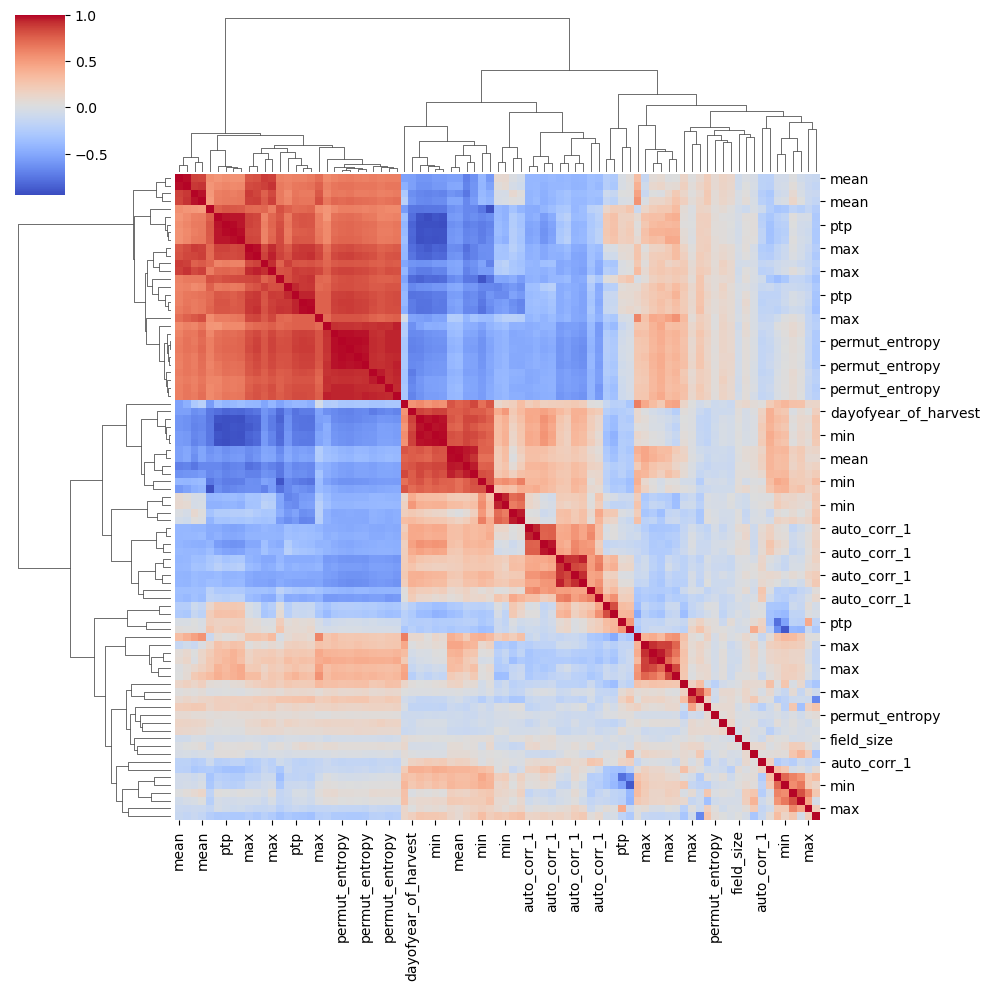

In [50]:
sns.clustermap(train_const_data.corr(), cmap='coolwarm')

In [51]:
train_const_data.isna().sum().sum()
sub_const_data.isna().sum().sum()

56

In [52]:
train_const_data = train_const_data.fillna(0)
sub_const_data   = sub_const_data.fillna(0)

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_regression
scaler = StandardScaler()
selector = SelectPercentile(f_regression, percentile=75)
selector.fit(scaler.fit_transform(train_const_data.drop('rice_yield', axis=1)), train_const_data.rice_yield)

SelectPercentile(percentile=75,
                 score_func=<function f_regression at 0x7ffa430e3040>)

<AxesSubplot:>

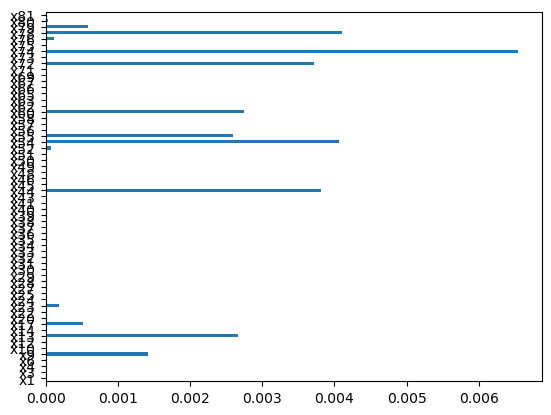

In [54]:
pd.Series(selector.pvalues_[selector.get_support()], index=selector.get_feature_names_out()).plot.barh()

In [55]:
train_const_data_pca = train_const_data.drop('rice_yield', axis=1)
sub_const_data_pca  = sub_const_data

# train_const_data_pca = pd.DataFrame(columns=selector.get_feature_names_out(), data=selector.transform(train_const_data.drop('rice_yield', axis=1)))
# sub_const_data_pca   = pd.DataFrame(columns=selector.get_feature_names_out(), data=selector.transform(sub_const_data))

# Create Model

In [578]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

def TrainTorch(xtrain, ytrain, val_data=(None, None), n_epochs=800, model='convnet'):
    
    # Set boolean for validating
    validating = True
    if val_data==(None, None):
        validating = False

    # To CUDA
    xtrain = xtrain.to('cuda')
    ytrain = ytrain.to('cuda')
    if validating:
        val_data = (val_data[0].to('cuda'), val_data[1].to('cuda'))
    
    # From Torch Tensor to Torch Dataset
    dataset_train = TensorDataset(xtrain, ytrain)
    if validating:
        dataset_val   = TensorDataset(*list(val_data))
        
    class TST(nn.Module):
        def __init__(self, seq_len, n_features, n_encoder_layers=1, nhead=4, d_model=4, dim_feedforward=112):
            super(TST, self).__init__()
            self.seq_len = seq_len
            self.n_features = n_features

            self.embedding = nn.Linear(n_features, d_model)

            self.positional_encoding = nn.Parameter(torch.zeros(seq_len, 1, d_model))

            encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
            self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_encoder_layers)

            self.flatten = nn.Flatten()

        def forward(self, x):
            # x has shape (batch_size, seq_len, n_features)
            x = self.embedding(x)
            x = x.permute(1, 0, 2)

            # add positional encoding
            x = x + self.positional_encoding[:self.seq_len, :, :]

            # permute input for transformer layer

            # apply transformer encoder
            x = self.encoder(x)

            # permute output to original shape
            x = x.permute(1, 0, 2)

            # flatten output
            # x = self.flatten(x)
        
            return x
    # class ConvNet
    class ConvNet(nn.Module):
        def __init__(self, n_features, time_series_length):
            super(ConvNet, self).__init__()
            
            feature_map_depth1 = 4
            n_neurons = 256
            kernel_size = 3
            
            self.transformer = TST(time_series_length, feature_map_depth1)
            
            self.conv1 = nn.Conv1d(n_features        , feature_map_depth1, kernel_size=kernel_size, stride=1, padding='same')
            self.conv2 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=kernel_size, stride=1, padding='same')
            self.conv3 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=kernel_size, stride=1, padding='same')
            self.conv4 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=kernel_size, stride=1, padding='same')
            self.conv5 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=kernel_size, stride=1, padding='same')
            self.conv6 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=kernel_size, stride=1, padding='same')
            
            self.conv_res1 = nn.Conv1d(n_features, feature_map_depth1, kernel_size=1, stride=1, padding='same')
            self.conv_res2 = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=1, stride=1, padding='same')
            
            self.bn1 = nn.BatchNorm1d(feature_map_depth1)
            self.bn2 = nn.BatchNorm1d(feature_map_depth1)
            self.bn3 = nn.BatchNorm1d(feature_map_depth1)
            self.bn4 = nn.BatchNorm1d(feature_map_depth1)
            self.bn5 = nn.BatchNorm1d(feature_map_depth1)
            self.bn6 = nn.BatchNorm1d(feature_map_depth1)
            
            self.globalconv = nn.Conv1d(feature_map_depth1, feature_map_depth1, kernel_size=time_series_length, stride=1, padding=0)
            
            self.drop = nn.Dropout(0.25)
            self.relu = nn.ReLU()
            self.pool = nn.MaxPool1d(2)

            # 1x1 convolution for residual connection
            
            self.fc1_res   = nn.Linear(feature_map_depth1, n_neurons)
            self.fc2_res   = nn.Linear(n_neurons, 1)
            
            self.fc1 = nn.Linear(feature_map_depth1, n_neurons)
            self.fc2 = nn.Linear(n_neurons, n_neurons)
            
            self.out = nn.Linear(feature_map_depth1, 1)
            
        def forward(self, x, return_encoding=False):
            
            x = x.permute(0, 2, 1) # (Para conv1d tiene que entrar batch size, features, seq_length
            # Conv1 Res
            x_res = self.conv_res1(x)  # apply 1x1 convolution to x_res
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.conv2(x)
            x = self.bn2(x)
            
            # Residual connection 
            x = x + x_res
            x = self.relu(x)
            # x = self.pool(x)
            
            # Conv1 Res
            x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
            x = self.conv3(x)
            x = self.bn3(x)
            x = self.relu(x)
            x = self.conv4(x)
            x = self.bn4(x)
            
            # Residual connection 
            x = x + x_res
            x = self.relu(x)
            # x = self.pool(x)
            
            # Conv1 Res
            x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
            x = self.conv5(x)
            x = self.bn5(x)
            x = self.relu(x)
            x = self.conv6(x)
            x = self.bn6(x)
            
            # Residual connection 
            x = x + x_res
            x = self.relu(x)
            # x = self.pool(x)
    
#             # Conv2 Res
#             x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
#             x = self.conv4(x)
#             x = self.relu(x)
#             x = self.conv5(x)
#             x = self.relu(x)

#             # Residual connection
#             x = x + x_res
#             # x = self.pool(x)
            
#             # Conv2 Res
#             x_res = self.conv_res2(x)  # apply 1x1 convolution to x_res
#             x = self.conv4(x)
#             x = self.relu(x)
#             x = self.conv5(x)
#             x = self.relu(x)

#             # Residual connection
#             x = x + x_res
            # x = self.pool(x)
    

            # Max Global Pooling         
            # x = x.permute(0, 2, 1)
            # x = self.transformer(x)
            # x = x.permute(0, 2, 1)
            x = self.globalconv(x).squeeze()
            # x = torch.max(x, dim=2)[0]
            # x = torch.mean(x, dim=2)
            # x = torch.flatten(x, 1, 2)
            
#             # Fully connected layers with residual connections
#             x_res = self.fc1_res(x)
#             x = self.fc1(x)
#             x = self.relu(x)
#             x = self.drop(x)
#             x = self.fc2(x)
#             x = self.relu(x)
            
#             # Residual connection
#             x = x + x_res

#             # Fully connected layers with residual connections
#             x_res = self.fc2_res(x)
#             x = self.fc2(x)
#             x = self.relu(x)
#             x = self.drop(x)
#             x = self.fc2(x)
#             # x = self.relu(x)
            
#             # Residual connection
#             x = x + x_res
            encoding = x
            # x = self.fc1(x)
            # x = self.relu(x)
            # x = self.drop(x)
            x = self.out(x)
            
            if return_encoding:
                return x, encoding
            else:
                return x
        
    class TransformerNet(nn.Module):
        def __init__(self, input_size, output_size, num_layers, hidden_size, num_heads, dropout):
            super(TransformerNet, self).__init__()
            self.embedding = nn.Linear(input_size, hidden_size)
            self.pos_embedding = nn.Embedding(100, hidden_size) # positional embedding
            self.transformer_encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, hidden_size, dropout, batch_first=True, norm_first=True)
            self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers)
            self.fc1 = nn.Linear(hidden_size, hidden_size)
            self.relu = nn.ReLU()
            self.out = nn.Linear(hidden_size, output_size)

        def forward(self, x):
            # x = x.permute(0, 2, 1)
            
            seq_length = x.shape[1]
            pos = torch.arange(seq_length).unsqueeze(0).repeat(x.shape[0], 1).to('cuda') # positional indices
            x = self.embedding(x) + self.pos_embedding(pos)
            x = self.transformer_encoder(x)
            x = F.max_pool1d(x.permute(0, 2, 1), seq_length).squeeze() # global pooling
            x = self.relu(self.fc1(x))
            return self.out(x)
        
    if model =='transformer':
        model = TransformerNet(input_size=n_features, output_size=1, num_layers=2, hidden_size=32, num_heads=16, dropout=0.15).to('cuda')
    elif model == 'convnet':
        model = ConvNet(n_features, time_series_length).to('cuda')
    else:
        raise Exception('Model has to be "convnet" or "transformer".')
    
    # Training parameters
    # optimizer = torch.optim.Adagrad(model.parameters(), lr=10**(-3.0), weight_decay=10**(-3), maximize=True)
    optimizer = torch.optim.AdamW(    model.parameters(), lr=10**(-4.0), weight_decay=10**(-1), maximize=False) # AdamW, 1 wd, 3.7 lr
    # optimizer = torch.optim.Adam(   model.parameters(), lr=10**(-4.0), weight_decay=10**(-2), maximize=False)
    # optimizer = torch.optim.SGD(    model.parameters(), lr=10**(-2.0), weight_decay=10**(-3), maximize=True)
    
    def smooth_r2_loss(y_pred, y_true, smooth_weight=0.3):
        ss_res = torch.sum(torch.square(y_true - y_pred))
        ss_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
        r2 = 1 - (ss_res + smooth_weight) / (ss_tot + smooth_weight)
        return r2
    criterion = nn.MSELoss()
    # criterion = smooth_r2_loss
    batch_size = 64
    epochs = n_epochs

    
    # Dataset to Dataloader
    dataloader_train = DataLoader(dataset_train    , batch_size=batch_size, shuffle=True)
    n_batches_train = (len(dataset_train) - 1)//batch_size+1
    if validating:
        dataloader_val   = DataLoader(dataset_val      , batch_size=batch_size, shuffle=True)
        n_batches_val   = (len(dataset_val  ) - 1)//batch_size+1
    else:
        n_batches_val = 1


    from sklearn.metrics import r2_score

    # Instantiate validation metrics
    stopping_counter = 0
    best_val_r2 = -np.inf

    # Training
    for epoch_n, epoch in tqdm(enumerate(range(epochs)), total=epochs):

        train_loss = 0.0
        model.train()
        for i, (x_, y_) in enumerate(dataloader_train):

            preds = model(x_)

            # Compute the loss
            loss = criterion(preds, y_)

            # Update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_r2 = 0.0
        if validating:

            for (x__, y__) in dataloader_val:

                # Forward Pass
                preds = model(x__)

                # Find the R2 score
                r2 = r2_score(y__.detach().cpu().numpy(), preds.detach().cpu().numpy())

                # Calculate R2 score
                val_r2 += r2

            patience = 20
            if val_r2 <= best_val_r2:
                stopping_counter += 1
                if stopping_counter == patience:
                    print(f'{stopping_counter} time(s) has the R2 score not improved. Finishing training...\n',
                        f'best epoch: {epoch_n - patience} training loss: {round(train_loss/n_batches_train, 4)} best val_R2: {np.round(best_val_r2/n_batches_val, 4)}'
                         )
                    break
            else:
                best_val_r2 = val_r2
                best_model = model
                stopping_counter = 0

        print(f'Training loss: {train_loss/n_batches_train:.4f}', 
        f'Validation R2 score: {val_r2/n_batches_val:.4f}',
        f'Stopping counter: {stopping_counter:02d}    ',
        end='\r')

    if validating:
        return best_model, best_val_r2/n_batches_val
    else:
        return model

## Prepare Data for Training

In [165]:
# Prepare data for training

# concat ts data with constant features
x = pd.concat([train_const_data_pca, train_ts_data.reset_index(level=1)], axis=1)\
.pipe(lambda x:x.set_index([x.index, 'level_1'])).drop(['season_WS'], axis=1)
xsub = pd.concat([sub_const_data_pca, sub_ts_data.reset_index(level=1)], axis=1)\
.pipe(lambda x:x.set_index([x.index, 'level_1'])).drop(['season_WS'], axis=1)

assert (x.columns == xsub.columns).all()

y = train_const_data.rice_yield.groupby(level=0).first().values.reshape(-1, 1)

# Reshape time series
n_samples = len(x)//14
time_series_length = (len(x) // n_samples)*0+14
n_features = x.shape[1]

# Convert to numpy array and reshape (n, length, features)
x    = x.values.reshape(n_samples, time_series_length, n_features)
xsub = xsub.values.reshape(  len(xsub.index.levels[0]), time_series_length, n_features)

display(x.shape, y.shape, xsub.shape)

(557, 14, 94)

(557, 1)

(100, 14, 94)

In [166]:
rand_state = np.random.randint(1, 373737)
rand_state = 285858
# rand_state = 222191
# 93344
# rand_state = 278122
# rand_state = 205873 # buena correlacion con leaderboard
# rand_state = 255631
# rand_state = 361712
print(rand_state)

# Split test set
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(1, random_state=rand_state, test_size=0.2)
idx_fulltrain, idx_test = list(splitter.split(x, crop_yield_data.target_class))[0]
# Make splits
xfulltrain = x[idx_fulltrain]
yfulltrain = y[idx_fulltrain]
xtest      = x[idx_test]
ytest      = y[idx_test]
target_fulltrain = crop_yield_data.target_class.loc[idx_fulltrain]
target_test      = crop_yield_data.target_class.loc[idx_test]

# Use train set for cross-validation
from sklearn.model_selection import KFold, StratifiedKFold
def KFoldTraining(x_, y_, **kwargs):

    # K folds
    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=rand_state+2)
    kfolds = list(kfold.split(x_, y_))
    
    # For each fold, scale data, train and append models
    models = []
    for i, fold in enumerate(kfolds):
        # Splitting
        train_idx, val_idx = fold[0], fold[1]
        xval      = x_[val_idx]
        yval      = y_[val_idx]
        xtrain    = x_[train_idx]
        ytrain    = y_[train_idx]
        
        # Add noise to ytrain
        # ytrain = ytrain + np.random.normal(0, 200, size=ytrain.shape)

        # Scaling
        # Instantiate scalers
        from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
        xtrain = scaler_x.fit_transform(xtrain.reshape(-1, xtrain.shape[2])).reshape(xtrain.shape)
        xval   = scaler_x.transform(xval.reshape(-1, xval.shape[2])).reshape(xval.shape)
        ytrain  = scaler_y.fit_transform(ytrain)
        yval    = scaler_y.transform(yval)

        # Cast to Tensors
        xtrain = torch.Tensor(xtrain)
        ytrain = torch.Tensor(ytrain)
        xval   = torch.Tensor(xval)
        yval   = torch.Tensor(yval)

        # Train and append model
        models.append(TrainTorch(xtrain, ytrain, (xval, yval), **kwargs))
        
    return models

def FullDataTraining(x, y, **kwargs):
    # Scaling
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    x    = scaler_x.fit_transform(x.reshape(-1, x.shape[2])).reshape(x.shape)
    y    = scaler_y.fit_transform(y)

    # Cast to Tensors
    x    = torch.Tensor(x)
    y    = torch.Tensor(y)

    # Train and append model
    return TrainTorch(x, y, **kwargs)

285858


## Train on training set

In [167]:
models_losses = KFoldTraining(xfulltrain, yfulltrain, model='convnet')

models = np.array(models_losses)[:, 0]
r2_scores = np.array(models_losses)[:, 1]

print('Average R2 on k-fold:' , r2_scores.mean())

  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 67 training loss: 0.3955 best val_R2: 0.5969


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 73 training loss: 0.3682 best val_R2: 0.5146


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 156 training loss: 0.3086 best val_R2: 0.4718


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 70 training loss: 0.402 best val_R2: 0.5849
Average R2 on k-fold: 0.5420373827181912


In [168]:
model = []
for i in [80]*4:
    model.append(FullDataTraining(xfulltrain, yfulltrain, n_epochs=i))
model = np.array(model)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [169]:
models_losses_transformer = KFoldTraining(xfulltrain, yfulltrain, model='transformer')

models_tr = np.array(models_losses_transformer)[:, 0]
r2_scores = np.array(models_losses_transformer)[:, 1]
print('Average R2 on k-fold:' , r2_scores.mean())

  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 59 training loss: 0.2257 best val_R2: 0.5592


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 11 training loss: 0.324 best val_R2: 0.612


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 20 training loss: 0.2757 best val_R2: 0.5103


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19    
 best epoch: 26 training loss: 0.2614 best val_R2: 0.5737
Average R2 on k-fold: 0.563786793369769


In [170]:
model_tr = []
for i in [10, 20, 30, 40]:
    model_tr.append(FullDataTraining(xfulltrain, yfulltrain, n_epochs=i, model='transformer'))
model_tr = np.array(model)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

## Evaluate with test set

### Function and Scaling

In [340]:
def MakePredictions(model, xtest, is_sklearn=False):
    if type(model) is np.ndarray or type(model) is list:
        kfold_preds = []
        if is_sklearn:
            for m in model:
                kfold_preds.append(m.predict(xtest).squeeze())
        else:
            if type(xtest) != torch.Tensor:
                xtest = torch.Tensor(xtest)
            for m in model:
                kfold_preds.append(m(xtest.to('cuda')).cpu().detach().numpy().squeeze())
        preds = np.mean(np.array(kfold_preds), 0)
    else:
        try:
            preds = model.predict(xtest).squeeze()
        except:
            if type(xtest) != torch.Tensor:
                xtest = torch.Tensor(xtest)
                preds = model(xtest.to('cuda')).cpu().detach().numpy().squeeze()

    return preds

def EvaluationPlot(model, xtest, ytest, title='', **kwargs):
                   
    preds = MakePredictions(model, xtest, **kwargs)
    
    # comparison preds, real
    from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as r2
    
    preds_df = pd.DataFrame(pd.concat([pd.Series(preds),
                                       pd.Series(ytest.squeeze())], axis=1))\
    .assign(error=lambda x:x[1] - x[0],
            mae=lambda x:mae(x[1], x[0]),
            mse=lambda x:np.sqrt(mse(x[1], x[0])),
            r2=lambda x:r2(x[1], x[0]))

    # preds_df.pipe(lambda x:sns.regplot(data=x, x=x[1], y=x[0]))
    # plt.plot(np.arange(preds_df[1].min(), preds_df[1].max()), np.arange(preds_df[1].min(), preds_df[1].max()), c='k', ls='-', alpha=0.35)
    # plt.title(title)
    # plt.show()
    print(title)
    display(preds_df.head(1))

In [172]:
# Scalers for test set
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
scaler_x_fulltrain = StandardScaler()
scaler_y_fulltrain = StandardScaler()
xfulltrain = scaler_x_fulltrain.fit_transform(xfulltrain.reshape(-1, xfulltrain.shape[2])).reshape(xfulltrain.shape)
yfulltrain = scaler_y_fulltrain.fit_transform(yfulltrain)
xtest = scaler_x_fulltrain.transform(xtest.reshape(-1, xtest.shape[2])).reshape(xtest.shape)
ytest = scaler_y_fulltrain.transform(ytest)

scaler_x_sub = StandardScaler()
scaler_y_sub = StandardScaler()
scaler_x_sub.fit(x.reshape(-1, x.shape[2]))
scaler_y_sub.fit(y)
xsub = scaler_x_sub.transform(xsub.reshape(-1, xsub.shape[2])).reshape(xsub.shape)

In [173]:
# Load 0.62 submission
ytrue = scaler_y_sub.transform(pd.read_csv('Version 11.csv').iloc[:, -1].rename('rice_yield').values.round(-1).reshape(-1, 1)).squeeze()

### sklearn benchmark

In [174]:
# sklearn benchmark
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor

# sk_model = SVR(C=10**4.5)
sk_model = AdaBoostRegressor(n_estimators=150)
sk_model.fit(xfulltrain.mean(1), yfulltrain)

EvaluationPlot(sk_model, xtest.mean(1), ytest, 'sklearn model vs test set')
EvaluationPlot(sk_model, xsub.mean(1) , ytrue, 'sklearn model vs 0.62 set')

sklearn model vs test set


,0,1,error,mae,mse,r2
0,0.680541,1.51175,0.831208,0.492211,0.585733,0.641626


sklearn model vs 0.62 set


,0,1,error,mae,mse,r2
0,0.805796,0.665169,-0.140627,0.189805,0.223851,0.890948


### NN Models

In [183]:
EvaluationPlot(models, xtest, ytest, 'KFold ConvNet vs Test Set')
EvaluationPlot(models, xsub , ytrue, 'KFold ConvNet vs 0.62 submission')

EvaluationPlot(model, xtest, ytest, '1 ConvNet vs Test Set')
EvaluationPlot(model, xsub , ytrue, '1 ConvNet vs 0.62 submission')

EvaluationPlot(models_tr, xtest, ytest, 'KFold Transformers vs Test Set')
EvaluationPlot(models_tr, xsub , ytrue, 'KFold Transformers vs 0.62 submission')

EvaluationPlot(model_tr, xtest, ytest, '1 Transformer vs Test Set')
EvaluationPlot(model_tr, xsub , ytrue, '1 Transformer vs 0.62 submission')

EvaluationPlot(np.append(models, models_tr, np.array([sk_model]*4)), xtest, ytest, 'Mix vs test submission')
EvaluationPlot(np.append(models, models_tr, np.array([sk_model]*4)), xsub , ytrue, 'Mix vs 0.62 submission')

KFold ConvNet vs Test Set


,0,1,error,mae,mse,r2
0,0.130923,1.51175,1.380826,0.475571,0.580765,0.647679


KFold ConvNet vs 0.62 submission


,0,1,error,mae,mse,r2
0,0.773057,0.665169,-0.107888,0.172578,0.236284,0.878497


1 ConvNet vs Test Set


,0,1,error,mae,mse,r2
0,0.486372,1.51175,1.025378,0.488555,0.59396,0.631487


1 ConvNet vs 0.62 submission


,0,1,error,mae,mse,r2
0,0.639269,0.665169,0.0259,0.162546,0.21905,0.895575


KFold Transformers vs Test Set


,0,1,error,mae,mse,r2
0,0.542929,1.51175,0.96882,0.479371,0.587955,0.638901


KFold Transformers vs 0.62 submission


,0,1,error,mae,mse,r2
0,0.85577,0.665169,-0.1906,0.201375,0.247527,0.866659


1 Transformer vs Test Set


,0,1,error,mae,mse,r2
0,0.486372,1.51175,1.025378,0.488555,0.59396,0.631487


1 Transformer vs 0.62 submission


,0,1,error,mae,mse,r2
0,0.639269,0.665169,0.0259,0.162546,0.21905,0.895575


TypeError: only integer scalar arrays can be converted to a scalar index

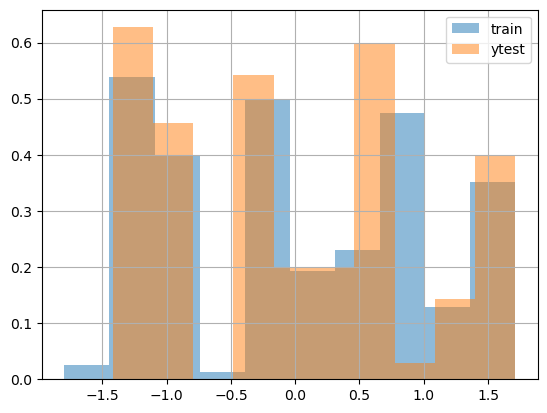

In [70]:
# Distribution of target variables
pd.Series(yfulltrain.squeeze()).hist(density=True, bins=10, label='train', alpha=0.5)
# pd.Series(preds).hist(density=True, bins=10, label='preds', alpha=0.5)
pd.Series(ytest.squeeze()).hist(density=True, bins=10, label='ytest', alpha=0.5)
plt.legend()

## Retrain with full data

In [579]:
# Train KFolds with validation data
models = KFoldTraining(x, y, model='convnet')

  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 108 training loss: 0.254 best val_R2: 0.6518


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 58 training loss: 0.3183 best val_R2: 0.485


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 58 training loss: 0.3163 best val_R2: 0.695


  0%|          | 0/800 [00:00<?, ?it/s]

20 time(s) has the R2 score not improved. Finishing training...ter: 19     
 best epoch: 65 training loss: 0.3053 best val_R2: 0.6285


In [580]:
# Average validation loss
r2_scores = np.array(models)[:, 1]
models = np.array(models)[:, 0]

print('Average R2 on k-fold:' , r2_scores.mean())

Average R2 on k-fold: 0.6150930851921638


In [238]:
# Train once on all data
model_full = []
for i in np.linspace(30, 70, 4, dtype=int):
    model_full.append(FullDataTraining(x, y, n_epochs=i, model='transformer'))

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

In [581]:
x_scaled = scaler_x_sub.transform(x.reshape(-1, x.shape[2])).reshape(x.shape)

In [582]:
def GetEncodings(x_basic):
    encodings = []
    for m in models:
        encodings.append(m(torch.Tensor(x_basic).to('cuda'), return_encoding=True)[1].cpu().detach().numpy())
    return np.array(encodings).mean(0)

In [592]:
# sklearn benchmark
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

sk_model = CatBoostRegressor(n_estimators=300, learning_rate=10**-2, reg_lambda=10**1.4, verbose=False)
sk_model2 = XGBRegressor(n_estimators=200, learning_rate=10**-2, reg_lambda=10**1.4)
# sk_model2 = AdaBoostRegressor(n_estimators=200, learning_rate=10**-0.7)
x_enhanced = np.hstack([x_scaled.mean(1), GetEncodings(x_scaled)])
xsub_enhanced = np.hstack([xsub.mean(1), GetEncodings(xsub)])
sk_model.fit(x_scaled.mean(1), scaler_y_sub.transform(y))
sk_model2.fit(x_scaled.mean(1), scaler_y_sub.transform(y))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [593]:
EvaluationPlot(models, xsub, ytrue)
EvaluationPlot(model_full, xsub, ytrue)
EvaluationPlot([sk_model, sk_model2], xsub.mean(1), ytrue, is_sklearn=True)

,0,1,error,mae,mse,r2
0,0.638133,0.665169,0.027036,0.18178,0.236904,0.877859


,0,1,error,mae,mse,r2
0,0.819741,0.665169,-0.154572,0.19631,0.235424,0.87938


,0,1,error,mae,mse,r2
0,0.660963,0.665169,0.004207,0.086945,0.122313,0.967442


# Make predictions and submit

In [596]:
# sub_preds = np.array(kfold_preds).mean(0)
# # sub_preds = model_full(xsub.to('cuda')).cpu().detach().numpy()
sub_preds = scaler_y_sub.inverse_transform(MakePredictions([sk_model, sk_model2], xsub.mean(1), is_sklearn=True).reshape(-1, 1)).squeeze()

sub_preds

array([7156.65655641, 6035.80138   , 6272.46051574, 7084.62839663,
       6083.71554982, 7080.91880717, 6024.32096524, 6068.33079284,
       7118.67820404, 7104.11725817, 6272.94249671, 6195.69147377,
       6054.98483738, 6076.14777078, 6324.72532085, 7175.00524247,
       6098.1470847 , 6148.28407274, 5988.20029229, 7098.96741698,
       7172.43488512, 6078.267865  , 7181.57013205, 6172.76223661,
       7137.18396439, 7186.87780944, 7096.68647894, 6179.41691884,
       6024.88138155, 6161.05581391, 6143.11408837, 6020.43201813,
       7137.78738729, 7142.50575495, 7147.42280962, 7148.12985652,
       6094.2684239 , 6070.91802341, 6932.34560439, 6124.92740309,
       7162.44299434, 6004.25761956, 6064.41758315, 7153.0927396 ,
       6025.66331843, 6144.43112957, 6074.90614477, 7134.79274977,
       6224.2238243 , 6408.85787764, 7172.42969049, 7195.72252607,
       5990.30701784, 7220.31940835, 6591.0380838 , 7271.50633353,
       7075.91820845, 7167.47960627, 5988.47239118, 6166.92584

In [597]:
submission_df = pd.read_csv('Challenge_2_submission_template.csv')
submission_df['Predicted Rice Yield (kg/ha)'] = sub_preds
submission_df.head()

,ID No,District,Latitude,Longitude,"Season(SA = Summer Autumn, WS = Winter Spring)","Rice Crop Intensity(D=Double, T=Triple)",Date of Harvest,Field size (ha),Predicted Rice Yield (kg/ha)
0,1,Chau_Phu,10.542192,105.187920,WS,T,10-04-2022,1.40,7156.656556
1,2,Chau_Thanh,10.400189,105.331053,SA,T,15-07-2022,1.32,6035.801380
2,3,Chau_Phu,10.505489,105.203926,SA,D,14-07-2022,1.40,6272.460516
3,4,Chau_Phu,10.523520,105.138274,WS,D,10-04-2022,1.80,7084.628397
4,5,Thoai_Son,10.294660,105.248528,SA,T,20-07-2022,2.20,6083.715550


In [186]:
submission_df.to_csv('Version 15.csv', index=False)